<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='imgs/UFF.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

### Machine Learning
# Practical Work 1: Recognizing Iris flowers

### [Ícaro Goulart Faria Motta França](http://icaromotta.com)
#### [Instituto de Computação](http://www.ic.uff)
#### [Universidade Federal Fluminense](http://www.uff.br)
$\renewcommand{\vec}[1]{\boldsymbol{#1}}$

### Códigos

** Primeiro adicionamos os imports das bibliotecas que serão usadas no projeto **

In [28]:
import random, math
import itertools
import numpy as np
# ploting support stuff
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
seaborn.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import load_iris
from sklearn import model_selection
from matplotlib import style
import pdb; 

style.use('ggplot')

# Fixed seed to make the results replicable - remove in real life!
#random.seed(56)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

** Carregamos o dataset da iris que usaremos no projeto **

In [29]:
iris_data = load_iris()
classNames = iris_data.target_names

In [30]:
print(iris_data.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])


** O primeiro algoritmo de classificação criado é o Logistic Regression **

In [31]:
class IcaroLogisticRegression():
    def __init__(self, params=None):
        if (params == None):
            self.params = {
                "learningRate": 0.1,
                "numIter": 1000
            }
    def _predictOne(self, x):
        return max((x.dot(w), c) for w, c in self.w)[1]
    
    def predict(self, X):
        return  [self._predictOne(i) for i in np.insert(X, 0, 1, axis=1)]
    
    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def learn(self, X, y):
        #insere uma coluna de 1 para representar o x0
        X = np.insert(X, 0, 1, axis=1)
        self.w = []
        m = X.shape[0]
        
        #itera nos 3 tipos de classe
        for i in np.unique(y):
            #divide o target em um e resto
            y_copy = np.where(y == i, 1, 0)
            w = np.ones(X.shape[1])
            
            for _ in range(self.params['numIter']):
                output = X.dot(w)
                errors = y_copy - self._sigmoid(output)
                w += self.params['learningRate'] / m * errors.dot(X)
            self.w.append((w, i))
        return self

** O segundo algoritmo de classificação criado é o Multinomial Naive Bayes **

In [32]:
class IcaroMultinomialNB():
    def __init__(self, params=None):
        if (params == None):
            self.params = {
                "alpha": 1.0
            }
        else:
            self.params = params
            
    def learn(self, X, y):
        
        #agrupamos em um dicionário os dados de treinamento por classe
        #onde a chave é a classe e o valor é um array contendos as tuplas das features
        separatedDict = {}
        for j in np.unique(y):
            separatedDict[j] = []

        for i in range(y.size):
            yClass = y[i]
            x = X[i]
            separatedDict[yClass].append(x)
        
        #número de amostras
        countSample = X.shape[0]
        
        #prior log probability
        #log(tamanho dos valores de cada grupo / número de amostras)
        self.classLogPrior = [np.log(len(value) / countSample) for key, value in separatedDict.items()]
        
        #contamos cada coluna de cada grupo. 
        #antes {0: [[1,2], [1,1]], 1: [[1,1], [1,1]]}
        #depois [[3,2], [2,2]]
        count = np.array([np.array(value).sum(axis=0) for key, value in separatedDict.items()]) + self.params['alpha']
        
        #calculamos o log probability para cada grupo
        #log(count/(soma de toda linha do count))
        self.featureLogProb = np.log(count/count.sum(axis=1)[np.newaxis].T)
        
        return self
    
    def predictLogProb(self, X):
        #soma (as linhas de (featureLogProb * x)) + classLogPrior
        return [(self.featureLogProb * x).sum(axis=1) + self.classLogPrior
            for x in X]
    
    def predict(self, X):
        #retorna o índice máximo de cada tupla de X
        return np.argmax(self.predictLogProb(X), axis=1)
    
    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)

#### Treinamento dos Algoritmos de Classificação

In [33]:
np.set_printoptions(precision=3)

#Usando primeiro algoritmo

logisticRegression = IcaroLogisticRegression()

X = iris_data.data;
y = iris_data.target;

train_size = .4
validation_size = .5

X_train, X_temp, y_train, y_temp = model_selection.train_test_split(X, y, test_size=train_size)
X_validation, X_test, y_validation, y_test = model_selection.train_test_split(X_temp, y_temp, test_size=validation_size)

logisticRegression.learn(X_train, y_train)
#print(logisticRegression.score(X_train, y_train))
#print(logisticRegression.score(X_validation, y_validation))

#Usando segundo algoritmo

nb = IcaroMultinomialNB()
nb.learn(X_train, y_train)
#print(nb.score(X_train, y_train))
#print(nb.score(X_validation, y_validation))

### Métricas


#### Acurácia da predição

In [34]:
lrPredictTrain = logisticRegression.predict(X_train)
nbPredictTrain = nb.predict(X_train)

lrPredictValidation = logisticRegression.predict(X_validation)
nbPredictValidation = nb.predict(X_validation)

print("Dados de Treino:")
print('LR: ' + str( round(accuracy_score(lrPredictTrain, y_train), 3) * 100) + '%')
print('NB: ' + str( round(accuracy_score(nbPredictTrain, y_train), 3) * 100) + '%')
print("\nDados de Validação:")
print('LR: ' + str( round(accuracy_score(lrPredictValidation, y_validation), 3) * 100) + '%')
print('NB: ' + str( round(accuracy_score(nbPredictValidation, y_validation), 3) * 100) + '%')


Dados de Treino:
LR: 96.7%
NB: 95.6%

Dados de Validação:
LR: 100.0%
NB: 100.0%


#### Matriz de Confusão

Função criada para criar o gráfico da matriz de confusão

In [35]:
def plotConfusionMatrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Matriz de confusão sem normalização
[[29  0  0]
 [ 0 27  3]
 [ 0  0 31]]


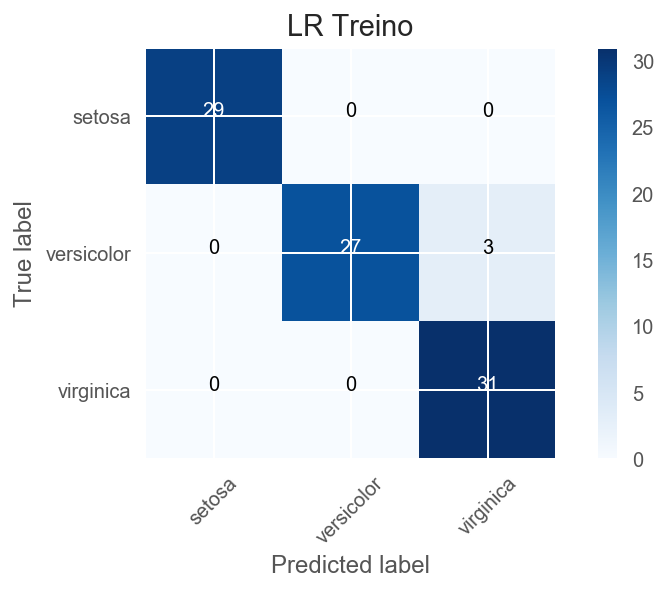

In [36]:
confusionMatrixLR_train = confusion_matrix(y_train, lrPredictTrain)
plotConfusionMatrix(confusionMatrixLR_train, classes=classNames,
                      title='LR Treino')

Matriz de confusão sem normalização
[[29  0  0]
 [ 0 26  4]
 [ 0  0 31]]


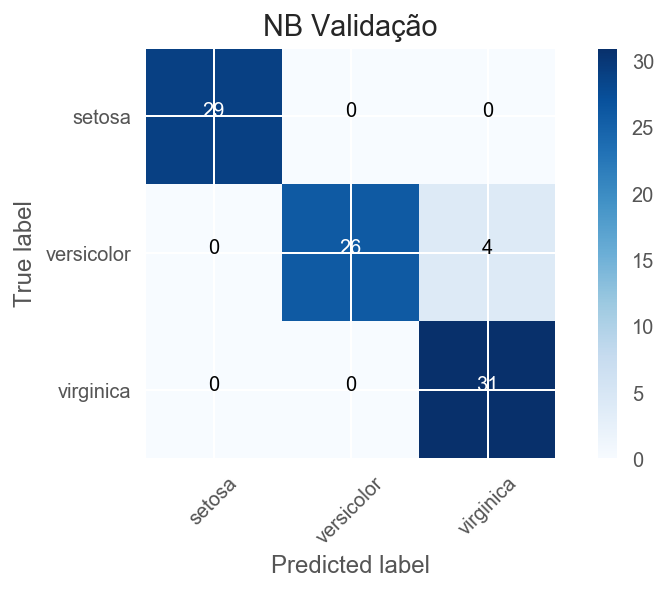

In [37]:
confusionMatrixNB_train = confusion_matrix(y_train, nbPredictTrain)
plotConfusionMatrix(confusionMatrixNB_train, classes=classNames,
                      title='NB Validação')

Matriz de confusão sem normalização
[[ 7  0  0]
 [ 0 12  0]
 [ 0  0 11]]


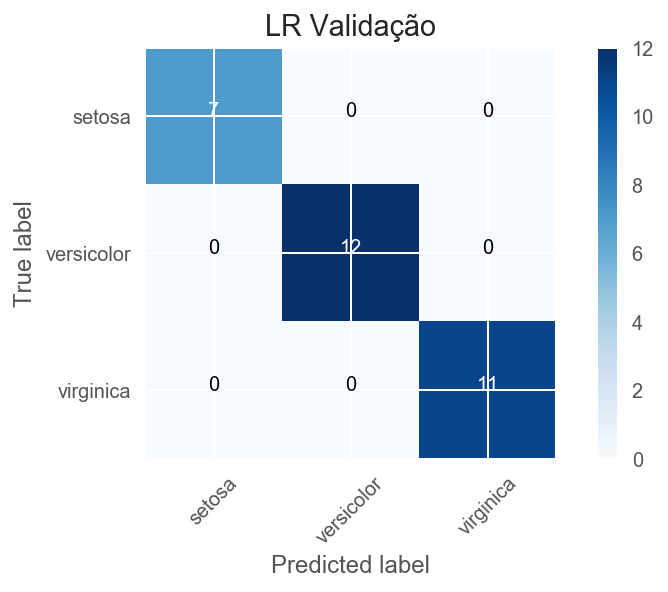

In [38]:
confusionMatrixLR_validation = confusion_matrix(y_validation, lrPredictValidation)
plotConfusionMatrix(confusionMatrixLR_validation, classes=classNames,
                      title='LR Validação')

Matriz de confusão sem normalização
[[ 7  0  0]
 [ 0 12  0]
 [ 0  0 11]]


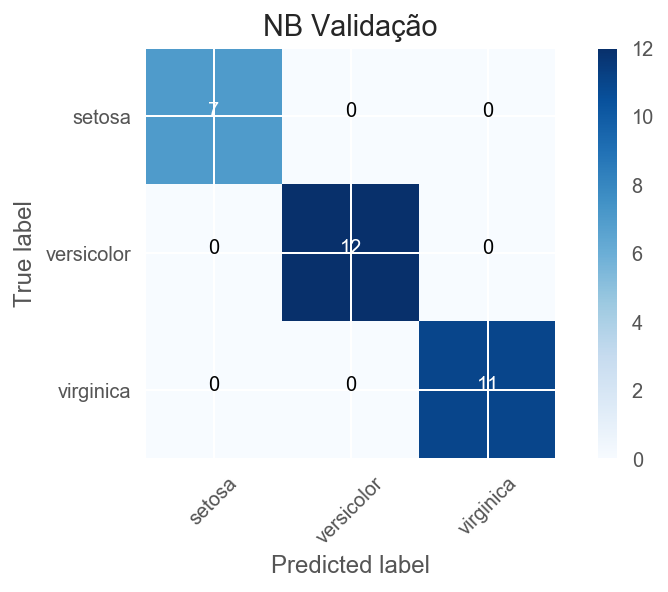

In [39]:
confusionMatrixNB_validation = confusion_matrix(y_validation, nbPredictValidation)
plotConfusionMatrix(confusionMatrixNB_validation, classes=classNames,
                      title='NB Validação')

#### Relatório de Classification

In [40]:
print("Dados de Treino:")
print('LR')
print(classification_report(y_train, lrPredictTrain))
print('NB')
print(classification_report(y_train, nbPredictTrain))
print("\nDados de Validação:")
print('LR')
print(classification_report(y_validation, lrPredictValidation))
print('NB')
print(classification_report(y_validation, nbPredictValidation))

Dados de Treino:
LR
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        29
          1       1.00      0.90      0.95        30
          2       0.91      1.00      0.95        31

avg / total       0.97      0.97      0.97        90

NB
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        29
          1       1.00      0.87      0.93        30
          2       0.89      1.00      0.94        31

avg / total       0.96      0.96      0.96        90


Dados de Validação:
LR
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       1.00      1.00      1.00        12
          2       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        30

NB
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       1.00      1.00      1

### Conclusão

Na maior parte dos casos o algoritmo de classificação Logistic Regression obtem os melhores resultados quando comparado ao Multinomial Naive Bayes (MNB). Porque o MNB depende muito do sorteio aleatório do conjunto de dados de treino. Um conjunto de dados de treino ideal para o MNB precisa ser bem distribuído, contendo uma quantidade aproximada de features para cada classe.